# **Test generation of random equations**

In [1]:
from src.datagen import Equations
import jax.numpy as jnp
import cloudpickle
import hashlib
import os
import json
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import scienceplots

## Define what is necessary for the generation of equations

To use the `Equations` class from `datagen.py`, you need to provide the following parameters:

### Required Parameters

1. `n_vars` (int): 
   - Number of variables in the system of equations
   - Example: `n_vars = 3` for a system with three variables

2. `n_eqs` (int):
   - Number of equations to generate
   - Example: `n_eqs = 3` to generate a system of three equations

3. `max_addends` (int):
   - Maximum number of addends in each equation
   - Example: `max_addends = 3` means each equation can have up to 3 terms added together

4. `max_multiplicands` (int):
   - Maximum number of multiplicands in each addend
   - Example: `max_multiplicands = 2` means each term can have up to 2 factors multiplied together

5. `non_lins` (tuple of functions):
   - List of all possible non-linear functions to use
   - Example: `non_lins = (jnp.sin, jnp.cos)` to use sine and cosine functions

### Optional Parameters

6. `sym_non_lins` (list of strings, optional):
   - Symbolic expressions of the non-linearities for equation visualization
   - Example: `sym_non_lins = [r"\sin", r"\cos"]` for LaTeX representation

7. `distribution` (str, optional):
   - Distribution type for generating variable indices (default: "uniform")
   - Options: "uniform", "beta", "lognormal", "custom"
   - Example: `distribution = "uniform"`

8. `p` (array-like, optional):
   - Probabilities for custom distribution over the variables (required if `distribution` is "custom")
   - Example: `p = [0.2, 0.5, 0.3]

7. `seed` (int, optional):
   - Seed for reproducibility (default: 42)
   - Example: `seed = 42`


Let's do an example

In [10]:
non_lins = (jnp.sin, jnp.cos)
non_lin_syms = [r"\sin", r"\cos"]

config = {
    "n_vars": 3,
    "n_eqs": 3,
    "max_addends": 3,
    "max_multiplicands": 2,
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "distribution": "uniform",
    "p": None,
    "seed": 42
}

Here is the definition of two functions that help us creating unique names for the systems of equations based on their configuration's values

In [11]:
def filter_config(config):
    """Filter and convert the configuration into a deterministic, serializable format."""
    filtered_config = {}
    for key, value in config.items():
        if isinstance(value, tuple):  # Convert tuples of functions to names
            filtered_config[key] = tuple(v.__name__ if callable(v) else v for v in value)
        elif callable(value):  # Replace single functions with their name
            filtered_config[key] = value.__name__
        elif isinstance(value, dict):  # Recursively process nested dictionaries
            filtered_config[key] = filter_config(value)
        else:
            filtered_config[key] = value
    return filtered_config

def get_unique_name_from_config(config):
    # Filter out non-deterministic or non-serializable elements
    filtered_config = filter_config(config)
    
    # Convert the filtered dictionary to a JSON string with sorted keys
    config_string = json.dumps(filtered_config, sort_keys=True)
    
    # Generate a hash from the string representation
    config_hash = hashlib.md5(config_string.encode()).hexdigest()
    
    # Use the hash to create a unique filename
    filename = f"equations_{config_hash}"
    return filename

Here we can see a brief example of what happens when we ask for a filename

In [12]:
first_filename = get_unique_name_from_config(config)
print(first_filename)

equations_4210f467e25048f286ce3a9c892c0224


If we change the configuration, for example by setting a different non linearity, the name will be different

In [13]:
non_lins = (jnp.tan, jnp.cos)


config = {
    "n_vars": 3,
    "n_eqs": 3,
    "max_addends": 3,
    "max_multiplicands": 2,
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "distribution": "uniform",
    "p": None,
    "seed": 42
}

second_filename = get_unique_name_from_config(config)
print(first_filename, second_filename)

equations_4210f467e25048f286ce3a9c892c0224 equations_a0865418aa0304b0c478830b16bbc0d8


And going back to the original configuration we go back to the previous name

In [14]:
non_lins = (jnp.sin, jnp.cos)

config = {
    "n_vars": 3,
    "n_eqs": 3,
    "max_addends": 3,
    "max_multiplicands": 2,
    "non_lins": non_lins,
    "sym_non_lins": non_lin_syms,
    "distribution": "uniform",
    "p": None,
    "seed": 42
}

third_filename = get_unique_name_from_config(config)
print(first_filename, third_filename)

equations_4210f467e25048f286ce3a9c892c0224 equations_4210f467e25048f286ce3a9c892c0224


This is done because if we end up setting the same configuration of an existing system, we can autmatically check if it already exists, and then reading it instead of generating it, thus saving us time

## Generate the equations

To generate the equations with the specified configuration we just need to write this simple command `Equations(**config)`

In [8]:
save_dir = "Data"

if os.path.exists(os.path.join(save_dir, first_filename+'.pkl')):
    print("System already exists")
    with open(os.path.join(save_dir, first_filename+'.pkl'), 'rb') as f:
        system = cloudpickle.load(f)
else:
    # Save the system variable to a file
    with open(os.path.join(save_dir, first_filename+'.pkl'), 'wb') as f:
        system = Equations(**config)
        cloudpickle.dump(system, f)
    print(f"System saved as {first_filename}.pkl in directory {save_dir}")

System saved as equations_19c013bbbd907fa647a81cb9162a936e.pkl in directory Data


## Using the save_symb_expr Function

The `save_symb_expr` function is used to save the symbolic expressions of the equations in the system. To use this function, you need to provide the following parameters:

### Required Parameters

1. `filename` (str): 
   - The name of the file where the symbolic expressions will be saved
   - Example: `filename = "equations_symbolic.pdf"`

### Optional Parameters

2. `max_eq_per_page` (int, optional):
   - The maximum number of equations in each page of the PDF (default: 35)
   - Example: `max_eq_per_page = 30`

In [9]:
system.save_symb_expr(filename=os.path.join(save_dir, first_filename+'_symbolic.pdf'))

PDF saved as Data/equations_19c013bbbd907fa647a81cb9162a936e_symbolic.pdf


<Figure size 350x262.5 with 0 Axes>

In the case the system is viewed as a system of differential equations, it is obviously possible to solve the system using the integrator that you prefer by passing the system to function, we can use for example the function `solve_ivp` from scipy

In [10]:
time_interval = [0, 1]
t_eval = jnp.linspace(time_interval[0], time_interval[1], int(1e5)) 
initial_conditions = [0.1, 0.5, 1]
integration_method = 'BDF'

sol = solve_ivp(system, time_interval, initial_conditions, integration_method, t_eval=t_eval)
print(sol.y)

[[0.1        0.10002148 0.10004297 ... 1.52803401 1.5280446  1.5280552 ]
 [0.5        0.50000932 0.50001864 ... 0.77806333 0.77805888 0.77805443]
 [1.         1.00000927 1.00001855 ... 2.5162576  2.51626931 2.51628103]]


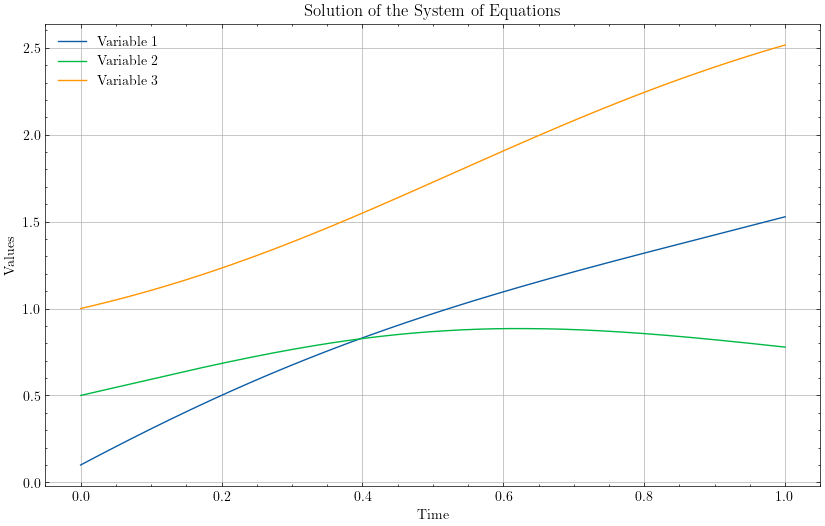

In [11]:
plt.style.use('science')

time_points = sol.t
solution = sol.y

plt.figure(figsize=(10, 6))
for i in range(solution.shape[0]):
    plt.plot(time_points, solution[i], label=f'Variable {i+1}')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Equations')
plt.legend()
plt.grid(True)
plt.show()

I now try different integrators to see if they give different solutions, just a sanity check for my handmade class.

In [12]:
sol_BDF = solve_ivp(system, time_interval, initial_conditions, 'BDF')
sol_RK45 = solve_ivp(system, time_interval, initial_conditions, 'RK45')
sol_RK23 = solve_ivp(system, time_interval, initial_conditions, 'RK23')
sol_Radau = solve_ivp(system, time_interval, initial_conditions, 'Radau')

In [13]:
last_values_BDF = sol_BDF.y[:, -1]
last_values_RK45 = sol_RK45.y[:, -1]
last_values_RK23 = sol_RK23.y[:, -1]
last_values_Radau = sol_Radau.y[:, -1]

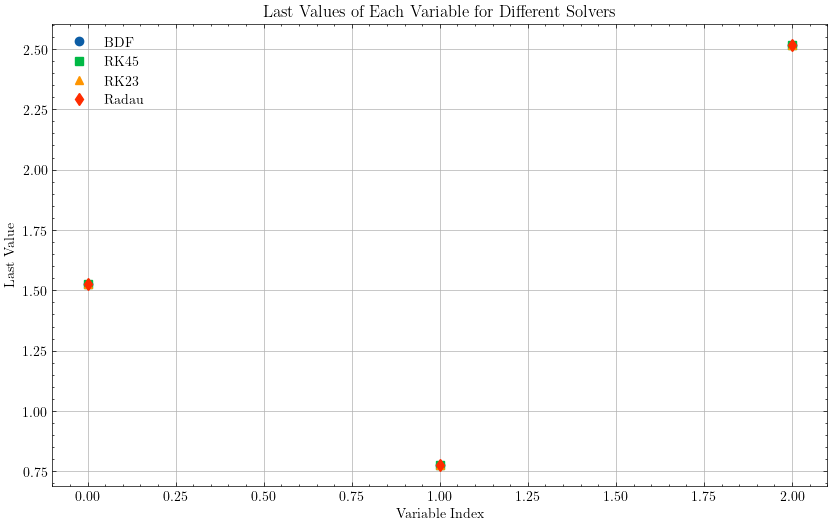

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(last_values_BDF, 'o', label='BDF')
plt.plot(last_values_RK45, 's', label='RK45')
plt.plot(last_values_RK23, '^', label='RK23')
plt.plot(last_values_Radau, 'd', label='Radau')
plt.xlabel('Variable Index')
plt.ylabel('Last Value')
plt.title('Last Values of Each Variable for Different Solvers')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
variable_1 = jnp.array((last_values_BDF[0], last_values_RK45[0], last_values_RK23[0], last_values_Radau[0]))
variable_2 = jnp.array((last_values_BDF[1], last_values_RK45[1], last_values_RK23[1], last_values_Radau[1]))
variable_3 = jnp.array((last_values_BDF[2], last_values_RK45[2], last_values_RK23[2], last_values_Radau[2]))

print(jnp.std(variable_1), jnp.std(variable_2), jnp.std(variable_3))

0.00022212451 0.0005638374 0.00044013726
